# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tableone import TableOne
import torch
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization

from synthcity.metrics.plots import plot_tsne
from synthcity.metrics.eval import Metrics
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "SAS_2"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
control = pd.read_csv(data_file_control, header=None, names=control_fnames)
print(control.head())

    time  censor  SEX   AGE  RACCAT  PRBEV  PROXAL  B_METACT  B_LDHNM  \
0   15.0     0.0    1  22.0       1      1       1         2    399.0   
1  233.0     1.0    1  20.0       1      1       1         2    340.0   
2  882.0     1.0    1  32.0       1      1       1         1    168.0   
3   51.0     1.0    1  48.0       1      0       1         2     82.0   
4  110.0     1.0    0  37.0       1      0       1         2    460.0   

   BECOGICD  DIAGTYPE  PRADJYN  LIVERMET  KRAS  
0       1.0         0        0         1     0  
1       0.0         1        0         1     2  
2       0.0         0        0         1     2  
3       1.0         1        0         1     1  
4       2.0         0        0         1     1  


In [4]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)

In [5]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [6]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

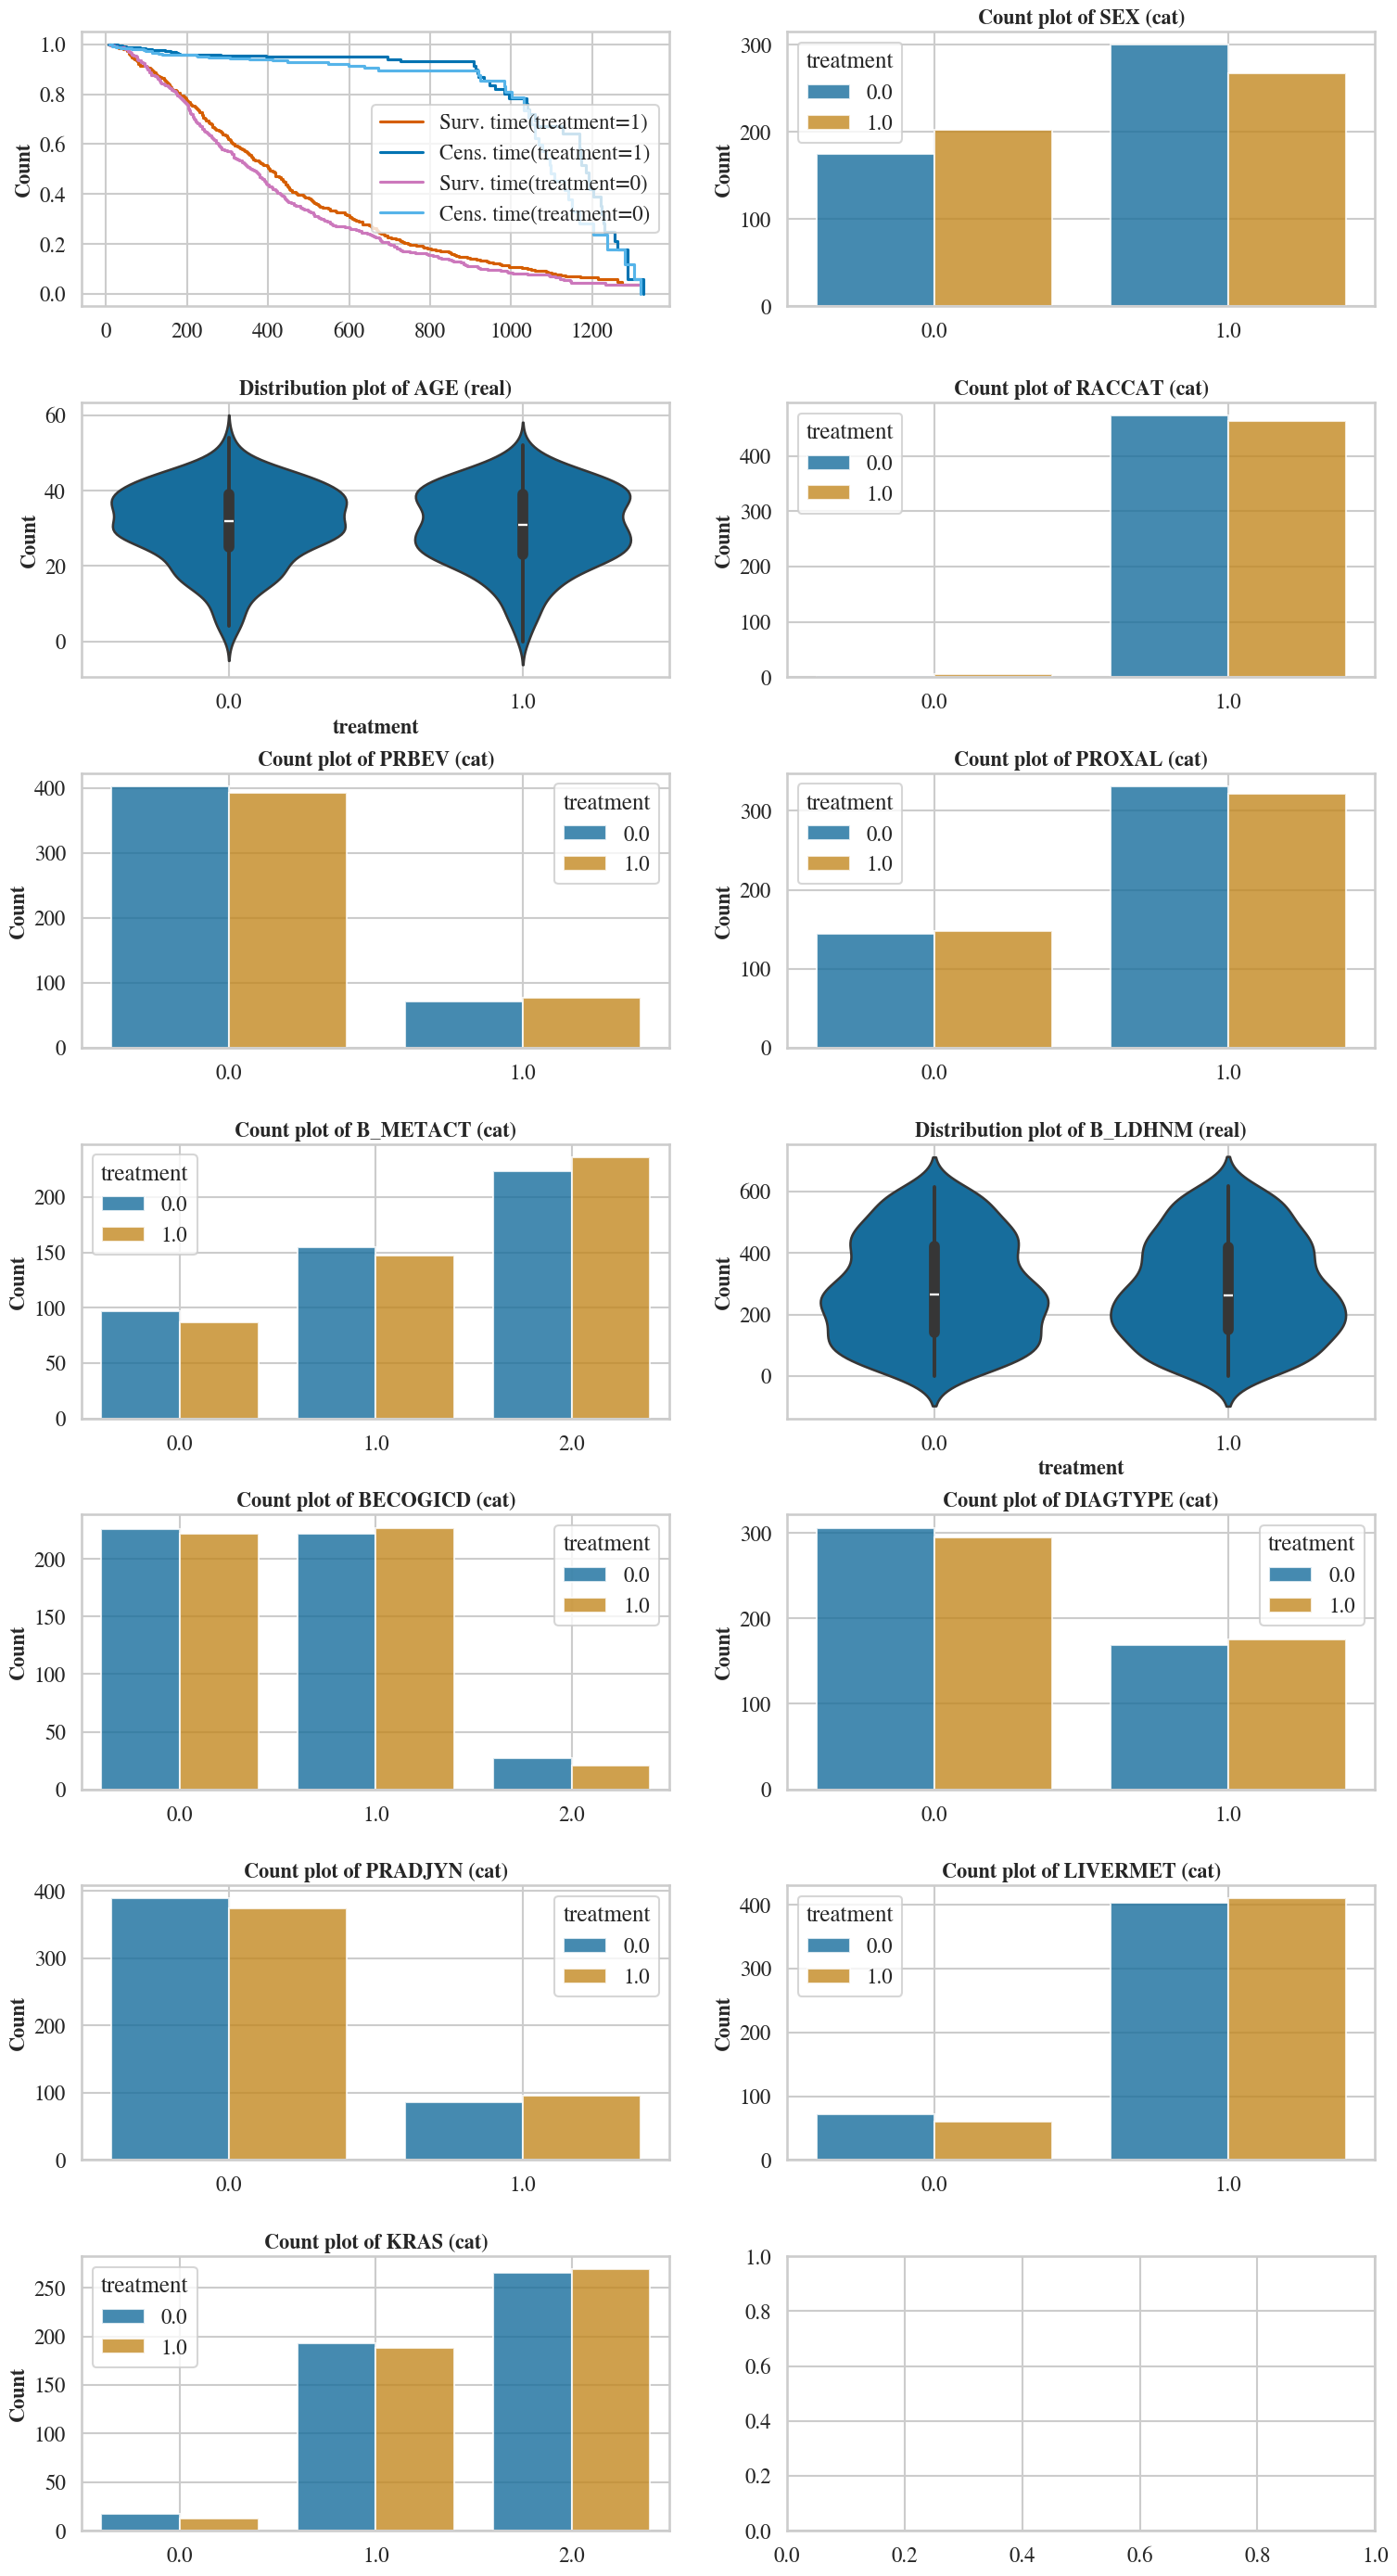

In [7]:
# TODO: Refactor
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [8]:
categorical = ['censor', 'SEX', 'RACCAT', 'PRBEV', 'PROXAL', 'B_METACT', 'BECOGICD', 'DIAGTYPE', 'PRADJYN', 'LIVERMET', 'KRAS']
continuous = ['time', 'AGE', 'B_LDHNM']
nonnormal = ['time']

In [9]:
table1 = TableOne(df_init, categorical=categorical + ['treatment'], continuous=continuous, 
                  groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by treatment                                                                       
                                      Missing              Overall                    0                    1 P-Value
n                                                              945                  475                  470        
time, median [Q1,Q3]                        0  358.0 [192.0,632.0]  336.0 [186.5,576.0]  383.0 [198.0,660.5]   0.051
censor, n (%)        0.0                                110 (11.6)            56 (11.8)            54 (11.5)   0.966
                     1.0                                835 (88.4)           419 (88.2)           416 (88.5)        
SEX, n (%)           0.0                                378 (40.0)           175 (36.8)           203 (43.2)   0.054
                     1.0                                567 (60.0)           300 (63.2)           267 (56.8)        
AGE, mean (SD)                              0          30.6 (10.

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [10]:
from execute import surv_hivae

# the datasets used for training is data_init_control
n_generated_dataset = 100

In [11]:
data_gen_control = surv_hivae.run(df_init_control_encoded,
                                  miss_mask_control, 
                                  true_miss_mask_control,
                                  feat_types_dict,
                                  n_generated_dataset)

Epoch: [ 0]  time: 0.1154, ELBO_train: -21.04622602, KL_z: 1.69222316, KL_s: 0.08821529, reconstruction loss: -19.26578757
Epoch: [100]  time: 2.8450, ELBO_train: -16.56346750, KL_z: 0.39388695, KL_s: 0.02918142, reconstruction loss: -16.14039913
Epoch: [200]  time: 5.3138, ELBO_train: -16.28309155, KL_z: 0.52129410, KL_s: 0.02761966, reconstruction loss: -15.73417778
Epoch: [300]  time: 8.1861, ELBO_train: -16.33763742, KL_z: 0.62484984, KL_s: 0.02922517, reconstruction loss: -15.68356241
Epoch: [400]  time: 10.8141, ELBO_train: -16.20751190, KL_z: 0.70686364, KL_s: 0.02821088, reconstruction loss: -15.47243738
Epoch: [500]  time: 13.6564, ELBO_train: -16.24342203, KL_z: 0.80039282, KL_s: 0.02878773, reconstruction loss: -15.41424148
Epoch: [600]  time: 16.4440, ELBO_train: -16.31906033, KL_z: 0.85751180, KL_s: 0.02976394, reconstruction loss: -15.43178459
Epoch: [700]  time: 18.9988, ELBO_train: -16.15992832, KL_z: 0.90231675, KL_s: 0.03244561, reconstruction loss: -15.22516596
Epoch

## 3. Analyze the generated data

### 3.1. Statistical analysis: one generated control group vs. initial control data

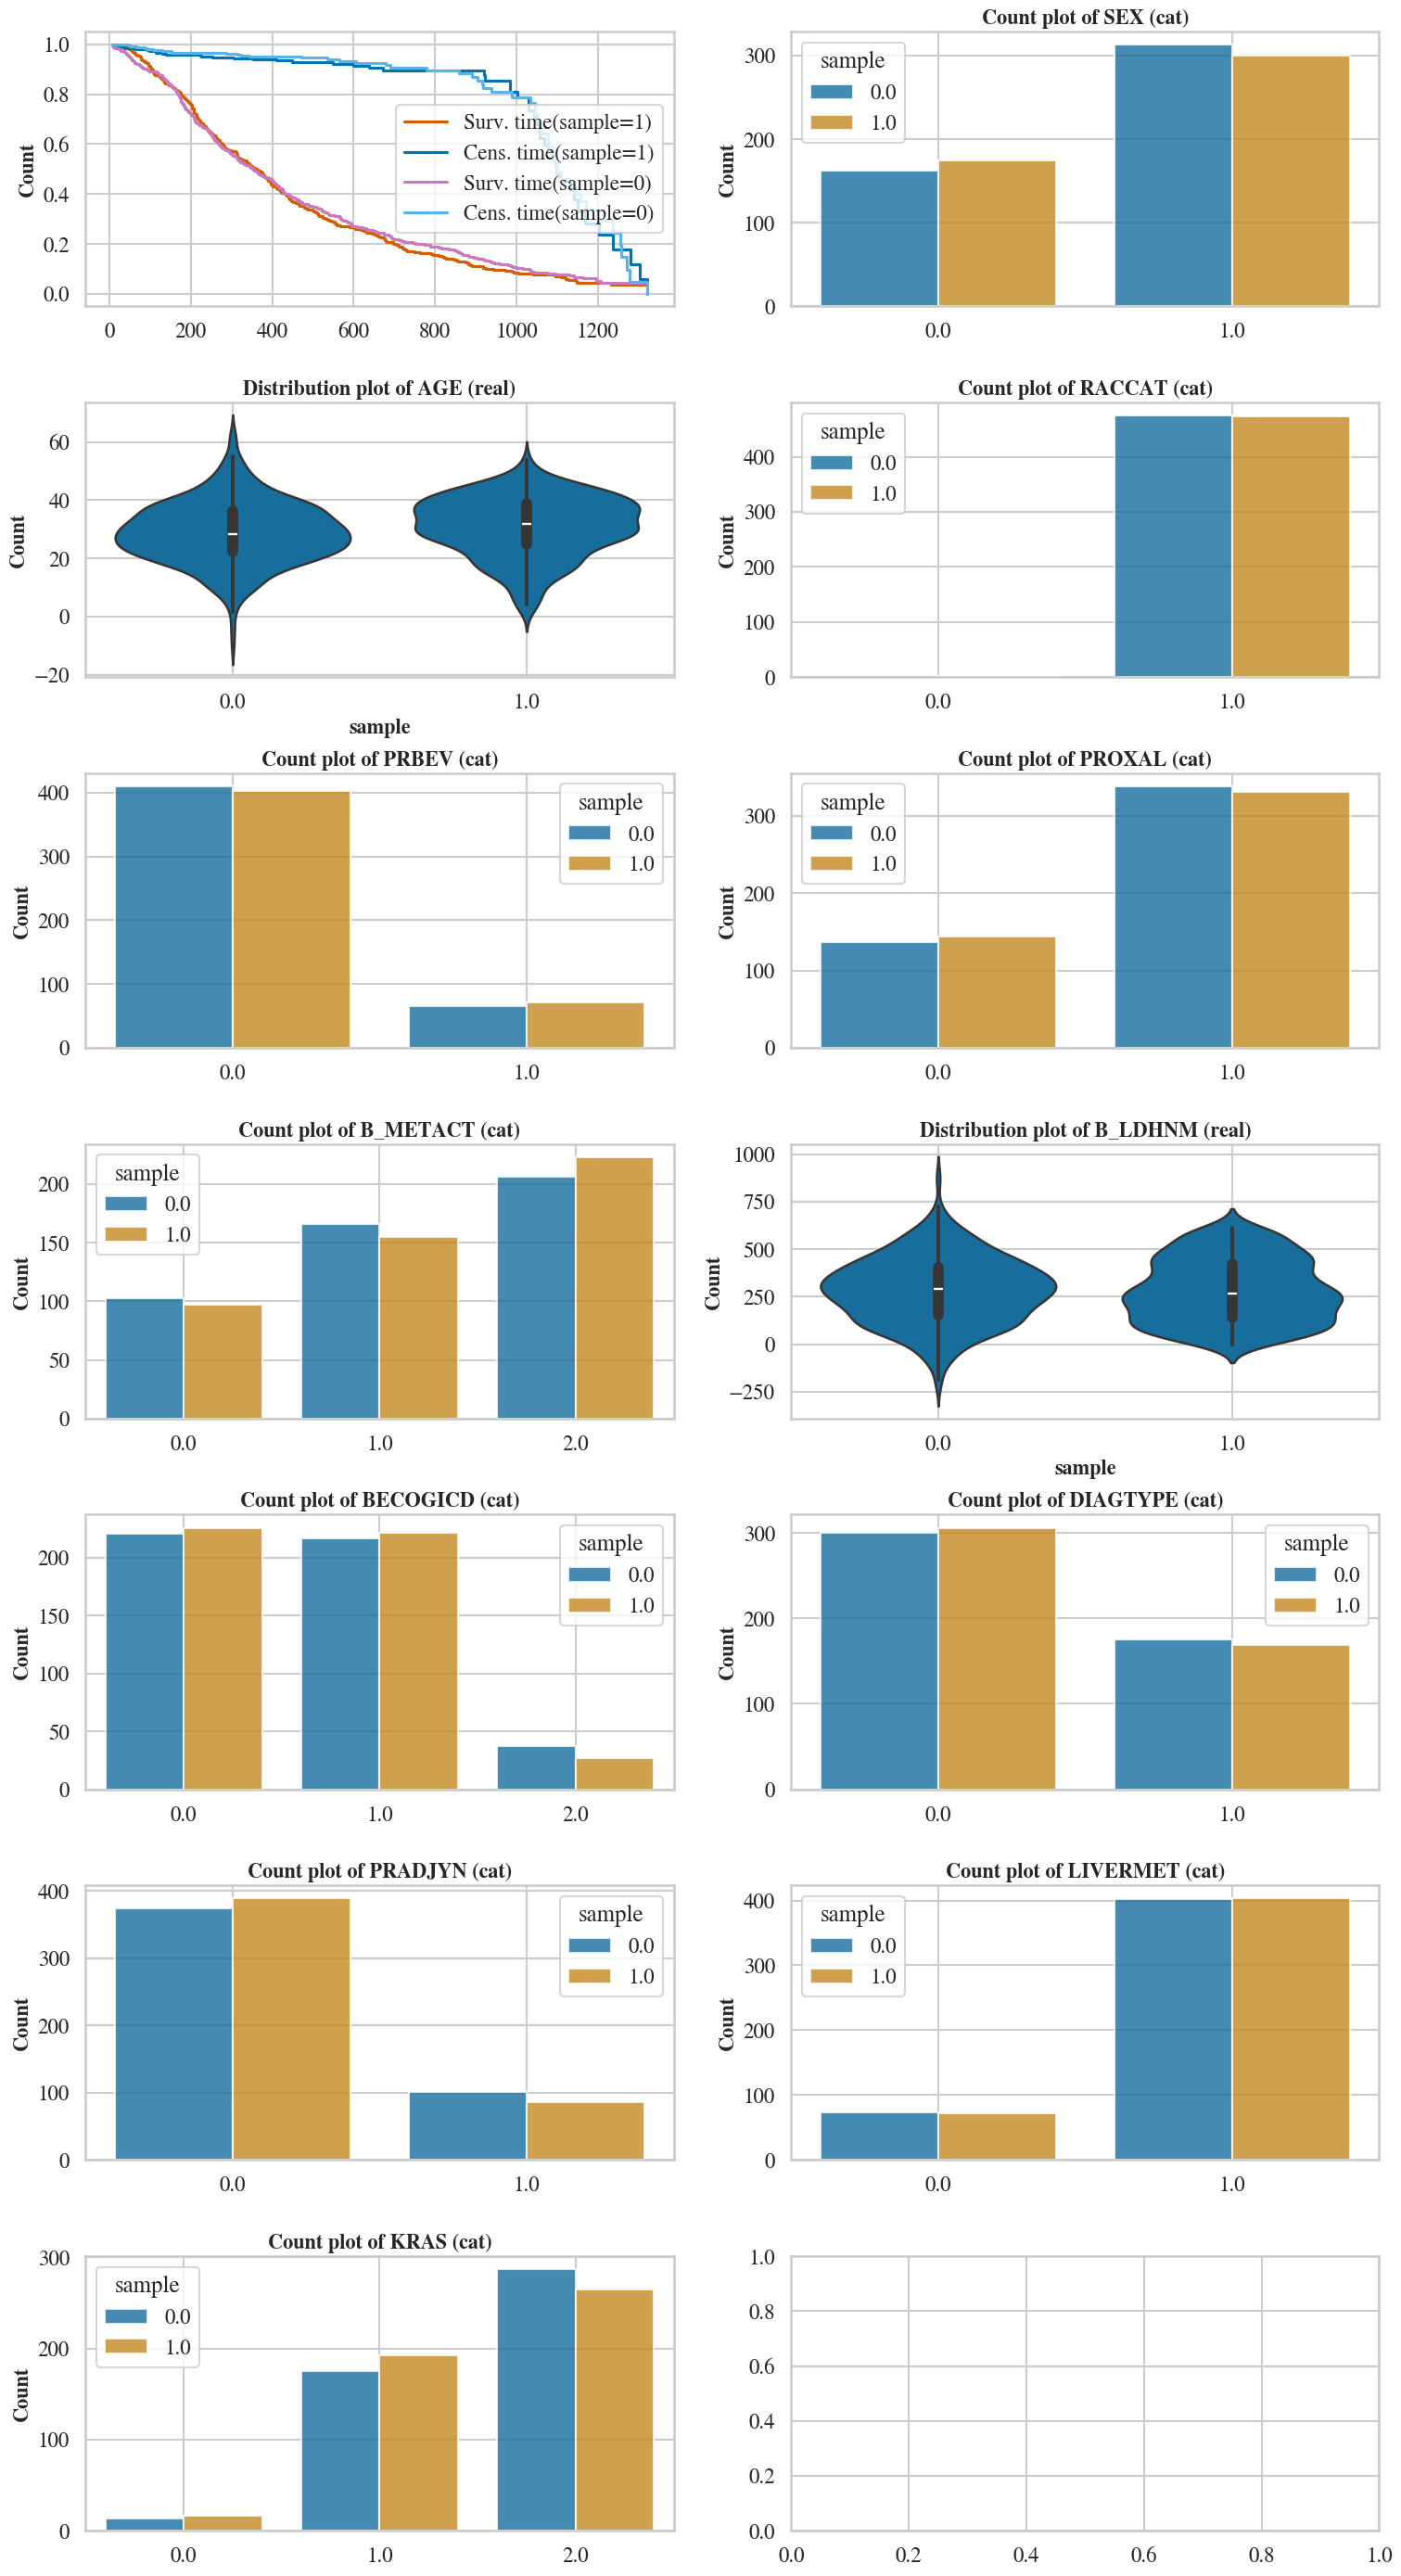

In [12]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)
df_init_control_ext['sample'] = 1

sel_idx = 2
df_gen_control_ext_sel = pd.DataFrame(data_gen_control[sel_idx].numpy(), columns=control_fnames)
df_gen_control_ext_sel['sample'] = 0

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

In [13]:
table1 = TableOne(df_control_sel, categorical=categorical + ['sample'], continuous=continuous, groupby='sample', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by sample                                                                       
                                   Missing              Overall                    0                    1 P-Value
n                                                           950                  475                  475        
time, median [Q1,Q3]                     0  333.3 [179.6,596.2]  329.1 [174.6,607.1]  336.0 [186.5,576.0]   0.768
censor, n (%)        0.0                             112 (11.8)            56 (11.8)            56 (11.8)   1.000
                     1.0                             838 (88.2)           419 (88.2)           419 (88.2)        
SEX, n (%)           0.0                             337 (35.5)           162 (34.1)           175 (36.8)   0.416
                     1.0                             613 (64.5)           313 (65.9)           300 (63.2)        
AGE, mean (SD)                           0          29.9 (10.6)          28.9 (10.7)    

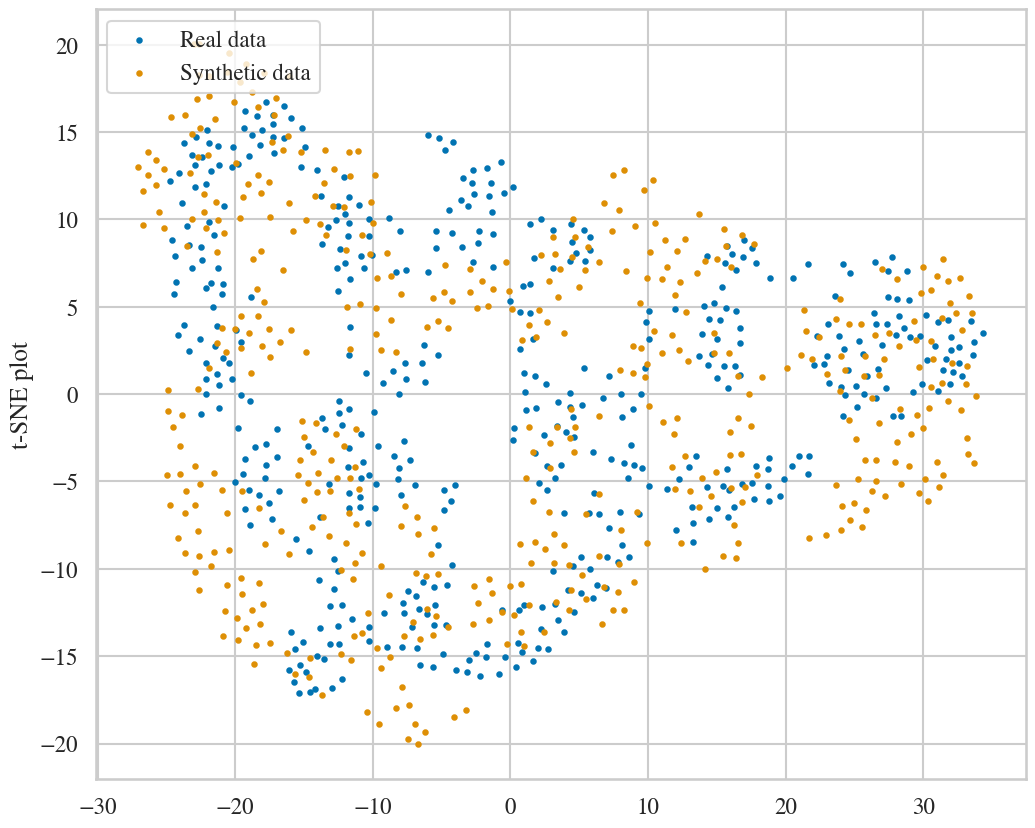

In [14]:
synthcity_dataloader_init = SurvivalAnalysisDataLoader(df_init_control, target_column = "censor", time_to_event_column = "time")
synthcity_dataloader_syn = SurvivalAnalysisDataLoader(df_gen_control_ext_sel, target_column = "censor", time_to_event_column = "time")
plot_tsne(plt, synthcity_dataloader_init, synthcity_dataloader_syn)

### 3.2. Statistical analysis: one generated control group vs. initial treated data

In [15]:
list_df_gen_control = []
for j in range(n_generated_dataset):
    df_gen_control_j = pd.DataFrame(data_gen_control[j].numpy(), columns=control_fnames)
    df_gen_control_j['treatment'] = 0
    list_df_gen_control.append(df_gen_control_j)

sel_idx = 0
df_gen_control_sel = list_df_gen_control[sel_idx]
df_syn_sel = pd.concat([df_init_treated, df_gen_control_sel], ignore_index=True)

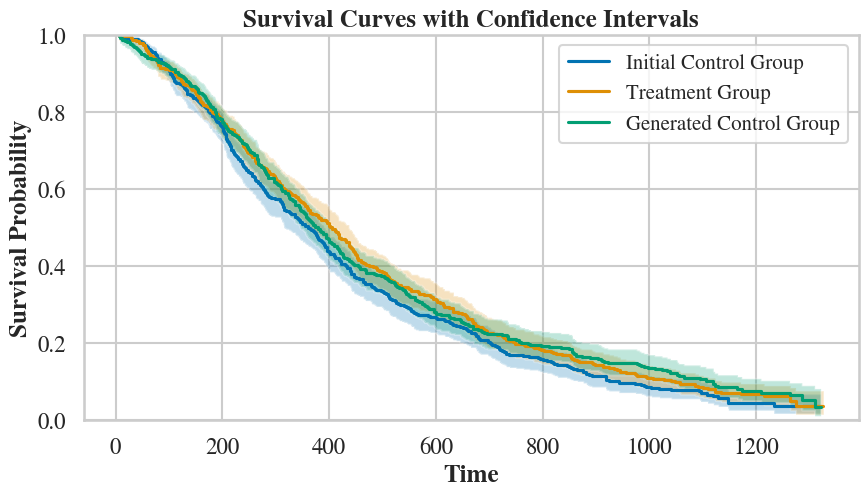

In [16]:
surv_time_control_init = df_init[df_init['treatment']==0].to_numpy()[:,0]
surv_ind_control_init = df_init[df_init['treatment']==0].to_numpy()[:,1].astype(bool)
surv_time_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,0]
surv_ind_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,1].astype(bool)
surv_time_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,0]
surv_ind_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,1].astype(bool)

uniq_time_control_init, surv_prob_control_init, conf_int_control_init = kaplan_meier_estimator(surv_ind_control_init, surv_time_control_init, conf_type="log-log")
uniq_time_treated_init, surv_prob_treated_init, conf_int_treated_init = kaplan_meier_estimator(surv_ind_treated_init, surv_time_treated_init, conf_type="log-log")
uniq_time_control_gen, surv_prob_control_gen, conf_int_control_gen = kaplan_meier_estimator(surv_ind_control_gen, surv_time_control_gen, conf_type="log-log")

plt.figure(figsize=(10, 5))
plt.step(uniq_time_control_init, surv_prob_control_init, where="post", label="Initial Control Group")
plt.fill_between(uniq_time_control_init, conf_int_control_init[0], conf_int_control_init[1], alpha=0.25, step="post")

plt.step(uniq_time_treated_init, surv_prob_treated_init, where="post", label="Treatment Group")
plt.fill_between(uniq_time_treated_init, conf_int_treated_init[0], conf_int_treated_init[1], alpha=0.25, step="post")

plt.step(uniq_time_control_gen, surv_prob_control_gen, where="post", label="Generated Control Group")
plt.fill_between(uniq_time_control_gen, conf_int_control_gen[0], conf_int_control_gen[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend(fontsize=15)
plt.xlabel("Time", fontweight="semibold")
plt.ylabel("Survival Probability", fontweight="semibold")
plt.title("Survival Curves with Confidence Intervals", fontweight="bold")
plt.show()

In [17]:
table1 = TableOne(df_syn_sel, categorical=categorical + ['treatment'], continuous=continuous, groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by treatment                                                                       
                                      Missing              Overall                    0                    1 P-Value
n                                                              945                  475                  470        
time, median [Q1,Q3]                        0  363.9 [190.1,641.0]  353.8 [187.0,599.8]  383.0 [198.0,660.5]   0.308
censor, n (%)        0.0                                129 (13.7)            75 (15.8)            54 (11.5)   0.067
                     1.0                                816 (86.3)           400 (84.2)           416 (88.5)        
SEX, n (%)           0.0                                384 (40.6)           181 (38.1)           203 (43.2)   0.127
                     1.0                                561 (59.4)           294 (61.9)           267 (56.8)        
AGE, mean (SD)                              0          30.1 (10.

## 4. Testing

### 4.1. Univariate testing

In [18]:
from utils.metrics import log_rank, cox_estimation

data_syn = []
for i in range(n_generated_dataset):
    df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=control_fnames)
    df_gen_control['treatment'] = 0
    data_syn.append(pd.concat([df_init_treated, df_gen_control], ignore_index=True))

LR_init, LR_syn = log_rank(df_init, data_syn)
coef_init, coef_syn, cox_p_value_init, cox_p_value_syn = cox_estimation(df_init, data_syn)

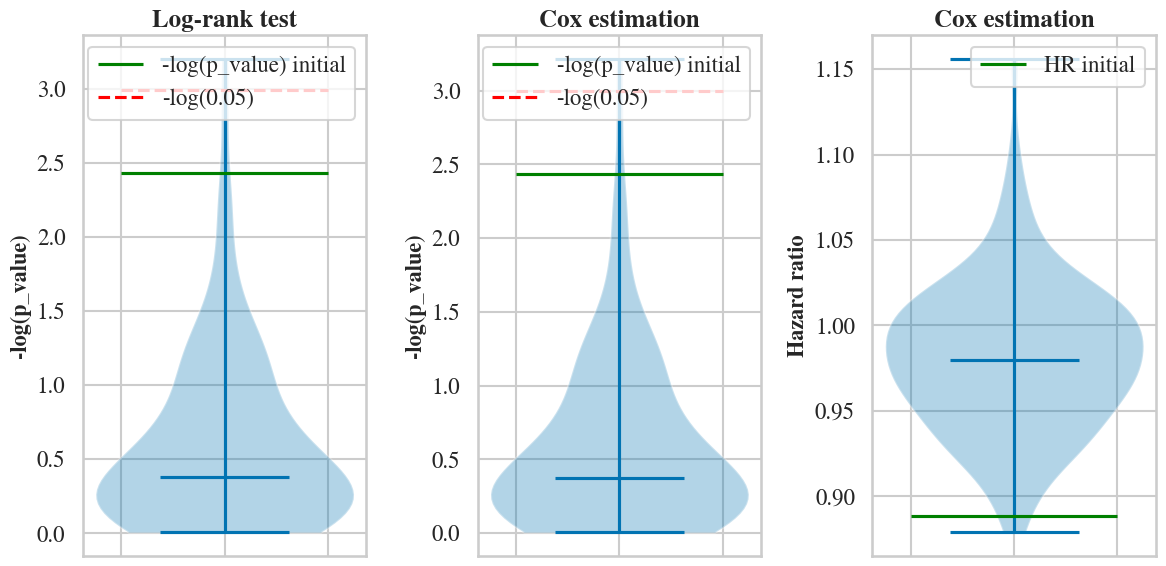

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.2. Stratified testing

#### 4.2.1. Categorical variable

In [20]:
from utils.metrics import strata_log_rank, strata_cox_estimation

# Stratified w.r. karnof analysis
strata_var = 'RACCAT'
df_init_strata = df_init.copy(deep=True)
df_init_treated_strata = df_init_treated.copy(deep=True)

data_syn_strata = []
for i in range(n_generated_dataset):
    df_gen_control_strata = pd.DataFrame(data_gen_control[i].numpy(), columns=control_fnames)
    df_gen_control_strata['treatment'] = 0
    data_syn_strata.append(pd.concat([df_init_treated_strata, df_gen_control_strata], ignore_index=True))

strata_LR_init, strata_LR_syn = strata_log_rank(df_init_strata, data_syn_strata, strata=strata_var)
strata_coef_init, strata_coef_syn, strata_cox_p_value_init, strata_cox_p_value_syn = strata_cox_estimation(df_init_strata, data_syn_strata, strata=strata_var)

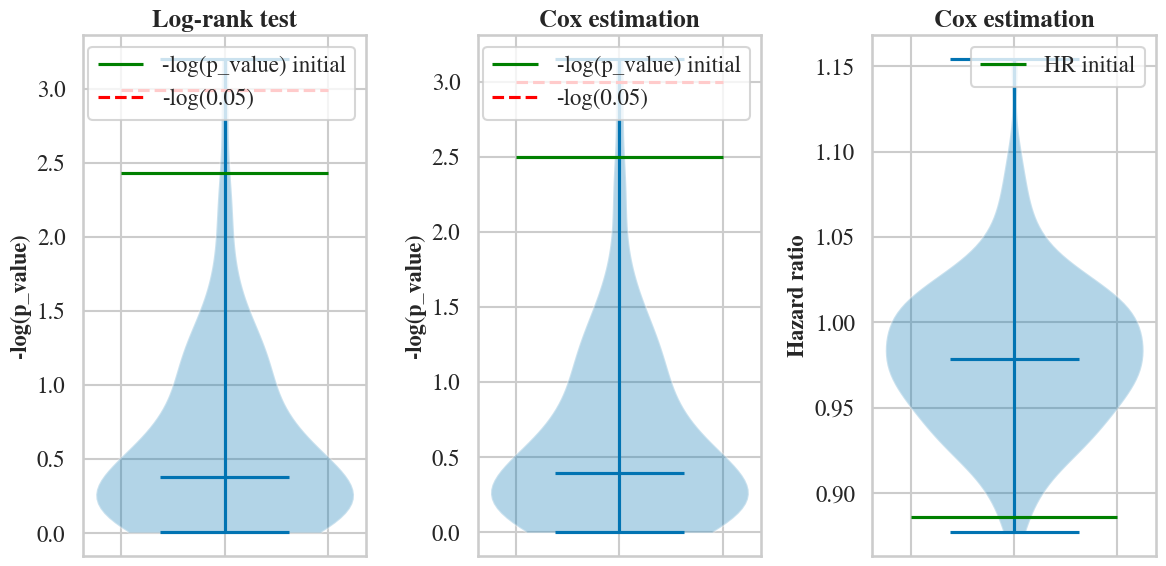

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(strata_LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(strata_LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(strata_cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(strata_cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(strata_coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(strata_coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.3. Metrics form synthcity: initial control data vs. all generated synthetic control groups

In [22]:
# Set display options
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each column

metrics = {
    'sanity': ['nearest_syn_neighbor_distance'],
    'stats': ['jensenshannon_dist', 'ks_test', 'survival_km_distance'],
    'performance': ['feat_rank_distance'],
    'detection': ['detection_xgb'],
    'privacy': ['k-map', 'distinct l-diversity', 'identifiability_score']
}
scores = ScoreEvaluator()
for j in range(n_generated_dataset):
    enable_reproducible_results(j)
    clear_cache()

    synthcity_dataloader_syn = SurvivalAnalysisDataLoader(list_df_gen_control[j], 
                                       target_column = "censor", 
                                       time_to_event_column = "time")

    evaluation = Metrics().evaluate(X_gt=synthcity_dataloader_init, # can be dataloaders or dataframes
                                    X_syn=synthcity_dataloader_syn, 
                                    reduction='mean', # default mean
                                    n_histogram_bins=10, # default 10
                                    metrics=metrics, # all metrics
                                    task_type='survival_analysis', 
                                    use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores.add(key, mean_score[key], errors[key], duration[key], direction[key])

synthcity_score = scores.to_dataframe()
synthcity_score

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.nearest_syn_neighbor_distance.mean,0.131888,0.374120,0.221877,0.047115,0.216430,0.064792,100,0,0.00,minimize
stats.jensenshannon_dist.marginal,0.003781,0.006944,0.005039,0.000580,0.004978,0.000645,100,0,0.02,minimize
stats.ks_test.marginal,0.959719,0.975018,0.968872,0.003012,0.969193,0.003368,100,0,0.01,maximize
stats.survival_km_distance.optimism,0.000368,0.064673,0.022884,0.011497,0.022551,0.013931,100,0,0.40,minimize
stats.survival_km_distance.abs_optimism,0.011110,0.066666,0.028166,0.009409,0.027361,0.011864,100,0,0.40,minimize
stats.survival_km_distance.sightedness,0.000000,0.053738,0.002467,0.008284,0.000000,0.000000,100,0,0.40,minimize
detection.detection_xgb.mean,0.632625,0.737536,0.688087,0.023629,0.685561,0.036556,100,0,0.06,minimize
privacy.k-map.score,6.000000,21.000000,15.250000,2.570506,15.000000,3.000000,100,0,0.02,maximize
privacy.distinct l-diversity.gt,10.000000,10.000000,10.000000,0.000000,10.000000,0.000000,100,0,0.03,maximize
privacy.distinct l-diversity.syn,2.000000,20.000000,11.290000,3.427229,11.500000,4.000000,100,0,0.03,maximize
